In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [2]:
science_direct_raw_df = pd.read_csv("science_direct_raw.csv", header=None, names=['raw'])
scopus_raw_df = pd.read_csv("scopus.csv")

### Processing ScienceDirect raw input

In [3]:
indices = []
publication_types = []
names = []
venues = []
authors = []
current_index = None
current_publication_type = None
current_name = None
current_venue = None
current_authors = []
line_counter = 0
skip_keywords = {"View PDF", "Abstract", "Figures", "Export"}
remove_phrases = {"Full text access", "Open access", "Open archive"}

for row in science_direct_raw_df['raw']:
    row = row.strip()
    if row.isdigit():
        if current_index is not None:
            indices.append(current_index)
            publication_types.append(current_publication_type)
            names.append(current_name)
            venues.append(current_venue)
            authors.append(", ".join(current_authors))
        current_index = int(row)
        current_publication_type = None
        current_name = None
        current_venue = None
        current_authors = []
        line_counter = 0
    elif current_index is not None:
        line_counter += 1
        if line_counter == 1:
            current_publication_type = row
            for phrase in remove_phrases:
                current_publication_type = current_publication_type.replace(phrase, "").strip()
        elif line_counter == 2:
            current_name = row
        elif line_counter == 3:
            current_venue = row
        elif line_counter > 3 and not any(keyword in row for keyword in skip_keywords):
            current_authors.append(row)

if current_index is not None:
    indices.append(current_index)
    publication_types.append(current_publication_type)
    names.append(current_name)
    venues.append(current_venue)
    authors.append(", ".join(current_authors))

science_direct_df = pd.DataFrame(
    {
        'Document Type': publication_types,
        'Title': names,
        'Source title': venues,
        'Authors': authors
    }
)

### Merging, removing duplicates and initial exclusions

In [4]:
print(f"Initial shape: {science_direct_df.shape[0] + scopus_raw_df.shape[0] }")

Initial shape: 5210


In [5]:
scopus_raw_df['web_source'] = ['Scopus'] * scopus_raw_df.shape[0]
science_direct_df['web_source'] = ['ScienceDirect'] * science_direct_df.shape[0]

raw_merge_df = scopus_raw_df.merge(
    science_direct_df, 
    on = ['Document Type', 'Title', 'Source title', 'Authors', 'web_source'], 
    how = 'outer'
)

In [6]:
duplicates_df = raw_merge_df[raw_merge_df.duplicated(subset='Title', keep=False)]
print("List of duplicated titles:")
print(list(duplicates_df['Title']))

List of duplicated titles:
['Index', 'Index', 'Index', 'Index', 'Subject Index', 'Subject Index', 'Subject Index', 'Subject Index', 'Subject Index', 'A Framework for Managing Requirements of Software Product Lines', 'A Monte Carlo tree search conceptual framework for feature model analyses', 'A Scientific Software Product Line for the Bioinformatics domain', 'A binary decision diagram lifted domain for analyzing program families', 'A customizable approach to full lifecycle variability management', 'A family of heuristic search algorithms for feature model optimization', 'A feature-based personalized recommender system for product-line configuration', 'A formal framework for software product lines', 'A framework for context-aware self-adaptive mobile applications SPL', 'A framework for managing the imperfect modularity of variability implementations', 'A framework for variable content document generation with multiple actors', 'A genetic algorithm for optimized feature selection with re

In [7]:
deduplicated_df = raw_merge_df.drop_duplicates(subset=['Title'])
print(f"Deduplicated shape: {deduplicated_df.shape[0]}")

Deduplicated shape: 4467


In [8]:
exclusion_types = [
    'Appendix B: Top Twenty 3D Vendors',
    'Book',
    'Book chapter',
    'Editorial',
    'Review',
    'Conference review',
    'Review article',
    'Software publication',
    'Short communication'
]
excluded_initial_df = deduplicated_df[~deduplicated_df['Document Type'].isin(exclusion_types)]

In [9]:
print(f"Initial exclusion shape: {excluded_initial_df.shape[0]}")

Initial exclusion shape: 3980


In [10]:
excluded_initial_df.to_csv("manual_analysis.csv")

### Bibliometric 

In [11]:
manualy_reviewed_df = pd.read_csv("reviewed.csv")

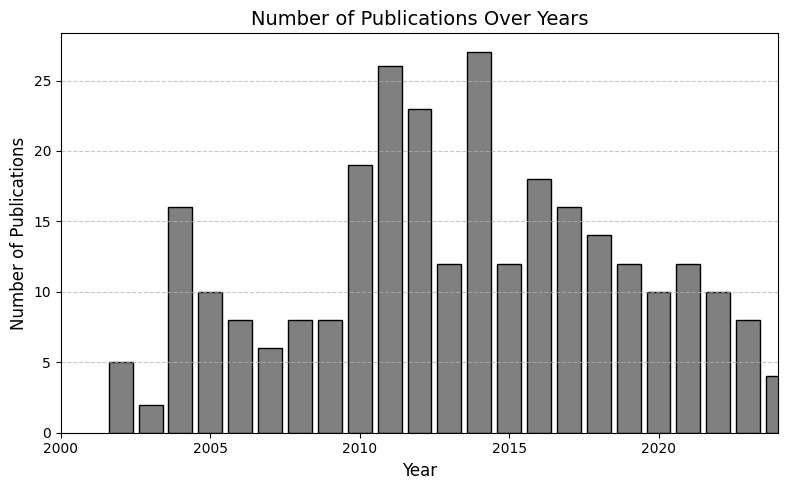

In [12]:
publications_per_year = manualy_reviewed_df.groupby('Year').count()['Title']

plt.figure(figsize=(8, 5))
plt.bar(publications_per_year.index, publications_per_year.values, color='gray', edgecolor='black')
plt.title('Number of Publications Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.xlim([2000, 2024])
plt.show()

In [13]:
manualy_reviewed_df.sort_values(by = 'Cited by', ascending=False)[['Title', 'Authors', 'Cited by']].to_csv("most_cited.csv")

In [14]:
print(f"Average citings: {manualy_reviewed_df['Cited by'].mean()}")

Average citings: 21.21875


In [15]:
source_counts = manualy_reviewed_df['Source title'].value_counts().iloc[:10]

source_counts

Source title
ACM International Conference Proceeding Series                                                                                          49
Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)    36
Journal of Systems and Software                                                                                                         11
Proceedings - International Conference on Software Engineering                                                                           7
IEEE Transactions on Software Engineering                                                                                                7
Empirical Software Engineering                                                                                                           6
Proceedings - International Computer Software and Applications Conference                                                                5
Information an

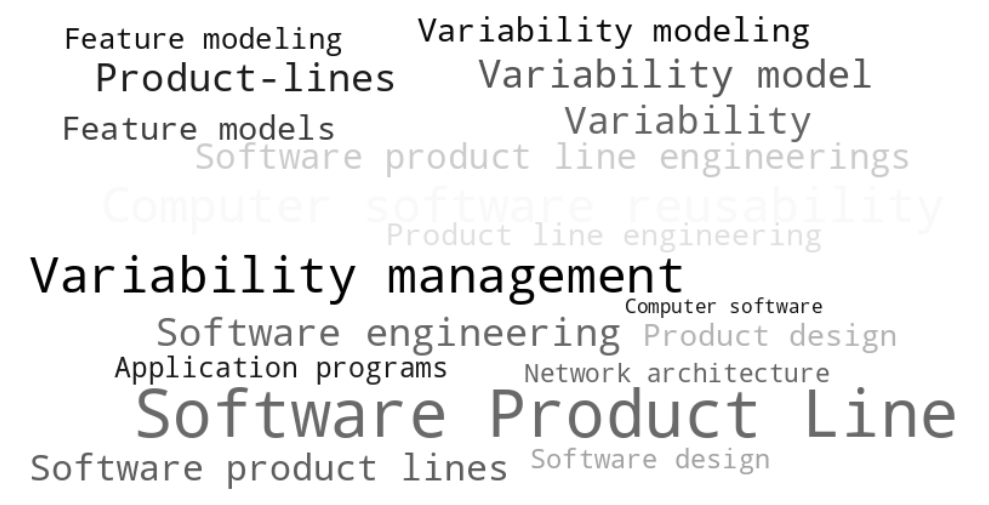

In [16]:
keywords_text = ', '.join(
    manualy_reviewed_df[~manualy_reviewed_df['Index Keywords'].isna()]['Index Keywords']
).replace("; ", ", ")

keywords_list = [keyword.strip() for keyword in keywords_text.split(',')]
keyword_counts = Counter(keywords_list)
top_keywords = dict(keyword_counts.most_common(18))

top_keywords['Software design'] = 20
top_keywords['Computer software'] = 10

wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    colormap='gray', 
    collocations=False
).generate_from_frequencies(top_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
contribution_types = [
    "Framework",
    "Method",
    "Modeling Approach",
    "Process",
    "Classification",
    "System/Tool",
    "Empirical Study"
]

def classify_contribution(row):
    title = str(row.get("Title", "")).lower()
    abstract = str(row.get("Abstract", "")).lower() if "Abstract" in row else ""
    
    if "framework" in title or "framework" in abstract:
        return "Framework"
    elif "method" in title or "methodology" in abstract:
        return "Method"
    elif "model" in title or "modeling" in abstract:
        return "Modeling Approach"
    elif "process" in title or "process" in abstract:
        return "Process"
    elif "classification" in title or "classification" in abstract:
        return "Classification"
    elif "tool" in title or "system" in abstract:
        return "System/Tool"
    elif "empirical" in title or "case study" in abstract or "evaluation" in abstract:
        return "Empirical Study"
    else:
        return "Other"

manualy_reviewed_df["Contribution Type"] = manualy_reviewed_df.apply(classify_contribution, axis=1)
contribution_summary = manualy_reviewed_df["Contribution Type"].value_counts()

contribution_summary

Contribution Type
Modeling Approach    122
System/Tool           48
Framework             41
Process               37
Other                 27
Method                 9
Empirical Study        2
Classification         2
Name: count, dtype: int64